In this file, we will create a fashion recommendation system with Machine Learning that will work like highly personalized online shopping recommendations. But before we go ahead, we need to know what a recommendation system is.

A recommendation system is a system that is programmed to predict future preferable items from a large set of collections. A recommendation system works either by using user preferences or by using the items most preferred by all users. The main challenge in building a fashion recommendation system is that it is a very dynamic industry. It changes very often when it comes to seasons, festivals, pandemic conditions like coronavirus and many more.

### Fashion Recommendation System with Machine Learning

Unlike other areas, fashion recommendations shouldn’t be based solely on personal taste and past activity of the customer. There are many external factors (many of which are emotional) that make creating a fashion recommendation system all the more complex. Public perceptions must be taken into account, as well as fashion rules, dress rules and current trends.

Let’s now dive into building a fashion recommendation system. We will simply start with importing all the packages we need for this task:

In [15]:
# pip install gdown
# !pip install fastai
!pip install annoy

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gdown
from fastai.vision import *
from fastai.metrics import accuracy, top_k_accuracy
from annoy import AnnoyIndex
import zipfile
import time
from google.colab import drive
%matplotlib inline

Now, we need to collect the [data](http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html) into our google drive, and we have to paste the **URLs** of those links to import the dataset in our notebook:

In [17]:
# get the meta data
url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pWnFiNlNGTVloLUk'
output = 'list_category_cloth.txt'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pTGNoWkhZeVpzbFk'
output = 'list_category_img.txt'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pdS1FMlNreEwtc1E'
output = 'list_eval_partition.txt'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pWnFiNlNGTVloLUk
To: /content/list_category_cloth.txt
100%|██████████| 882/882 [00:00<00:00, 1.20MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pTGNoWkhZeVpzbFk
To: /content/list_category_img.txt
21.4MB [00:00, 95.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pdS1FMlNreEwtc1E
To: /content/list_eval_partition.txt
22.2MB [00:00, 77.1MB/s]


'list_eval_partition.txt'

Now, let’s get all the images from our google drive:

In [18]:
# get the images
root_path = './'
url = 'https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb'
output = 'img.zip'
gdown.download(url, output, quiet=False)

with zipfile.ZipFile("img.zip","r") as zip_ref:
    zip_ref.extractall(root_path)

Downloading...
From: https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb
To: /content/img.zip
2.68GB [00:37, 72.0MB/s]


All the above files are also available in **fashion** folder in local drive

Now we will perform some data preparation and data cleaning steps to frame the data in a useful manner:

In [19]:
category_list = []
image_path_list = []
data_type_list = []

In [20]:
# category names
with open('list_category_cloth.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            category_list.append(line.split(' ')[0])

In [21]:
# category map
with open('list_category_img.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            image_path_list.append([word.strip() for word in line.split(' ') if len(word) > 0])

In [22]:
# train, valid, test
with open('list_eval_partition.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            data_type_list.append([word.strip() for word in line.split(' ') if len(word) > 0])

In [23]:
data_df = pd.DataFrame(image_path_list, columns=['image_path', 'category_number'])
data_df['category_number'] = data_df['category_number'].astype(int)
data_df = data_df.merge(pd.DataFrame(data_type_list, columns=['image_path', 'dataset_type']), on='image_path')
data_df['category'] = data_df['category_number'].apply(lambda x: category_list[int(x) - 1])
data_df = data_df.drop('category_number', axis=1)            

Now, the code below will convert all the images into embeddings:

In [24]:
train_image_list = ImageList.from_df(df=data_df, path=root_path, cols='image_path').split_by_idxs(
    (data_df[data_df['dataset_type']=='train'].index),
    (data_df[data_df['dataset_type']=='val'].index)).label_from_df(cols='category')

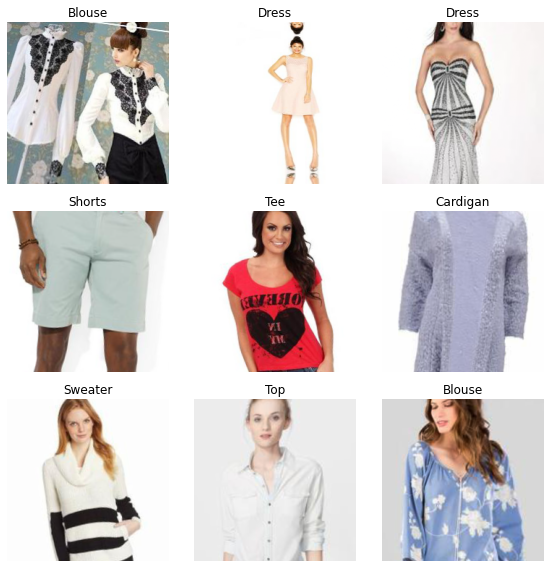

In [25]:
test_image_list = ImageList.from_df(df=data_df[data_df['dataset_type'] == 'test'], path=root_path, cols='image_path')

data = train_image_list.transform(get_transforms(), size=224).databunch(bs=128).normalize(imagenet_stats)
data.add_test(test_image_list)
data.show_batch(rows=3, figsize=(8,8))

Now, we will do some steps of transfer learning by using the resnet and PyTorch library to get the learning rate:

In [26]:
# see models available: https://docs.fast.ai/vision.models.html
# many options for Resnet, the numbers are the number of layers. 
# More layers are generally more accurate but take longer to train: resnet18, resnet34, resnet50, resnet101, resnet152
# get top 1 and top 5 accuracy
def train_model(data, pretrained_model, model_metrics):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner.lr_find()
    learner.recorder.plot(suggestion=True)
    return learner

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03
Min loss divided by 10: 1.20E-02


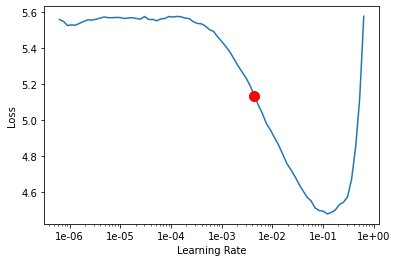

In [27]:
pretrained_model = models.resnet18 # simple model that can be trained on free tier
# pretrained_model = models.resnet50 # need pro tier, model I used

model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
learner = train_model(data, pretrained_model, model_metrics)

In [28]:
learner.fit_one_cycle(10, max_lr=1e-02)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,1.608434,1.469345,0.570075,0.570075,0.879450,31:01
1,1.580376,1.459542,0.571650,0.571650,0.882575,28:43
2,1.566543,1.496414,0.563900,0.563900,0.873250,28:26
3,1.551701,1.450563,0.575025,0.575025,0.884125,29:01
4,1.533731,1.374312,0.593700,0.593700,0.895725,28:27


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,1.608434,1.469345,0.570075,0.570075,0.879450,31:01
1,1.580376,1.459542,0.571650,0.571650,0.882575,28:43
2,1.566543,1.496414,0.563900,0.563900,0.873250,28:26
3,1.551701,1.450563,0.575025,0.575025,0.884125,29:01
4,1.533731,1.374312,0.593700,0.593700,0.895725,28:27
5,1.447546,1.333651,0.606750,0.606750,0.901275,28:29
6,1.415188,1.312733,0.614450,0.614450,0.904075,28:19
7,1.384807,1.272850,0.623150,0.623150,0.910025,28:43
8,1.352614,1.246690,0.630300,0.630300,0.913200,28:32
9,1.340365,1.244239,0.631975,0.631975,0.913750,28:03


Now, let’s evaluate the transfer learning model:

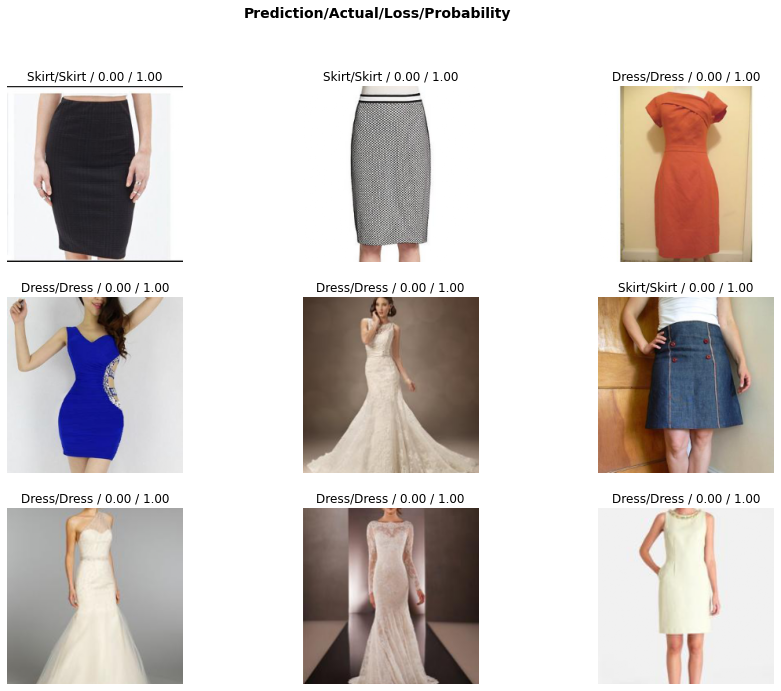

In [29]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(9, largest=False, figsize=(15,11), heatmap_thresh=5)

The output looks good, now before moving forward let’s save this model so that we could easily use it for our future tasks:

In [38]:
# saving the model (temporary, will lose model once environment resets)
learner.save('resnet-fashion')

Now, we will use the **FastAI** method to retrieve the image embeddings:

In [39]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [40]:
# load the trained model
def load_learner(data, pretrained_model, model_metrics, model_path):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner = learner.load(model_path)
    return learner

In [42]:
pretrained_model = models.resnet18 # simple model that can be trained on free tier
# pretrained_model = models.resnet50 # need pro tier

model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
# if gdrive not mounted:
# drive.mount('/content/drive') 
# model_path = "/content/drive/MyDrive/resnet18-fashion"
model_path = "/content/models/resnet-fashion"
learner = load_learner(data, pretrained_model, model_metrics, model_path)

Now we will use approximate nearest neighbours method to create a fashion recommendation system:

In [43]:
# takes time to populate the embeddings for each image
# Get 2nd last layer of the model that stores the embedding for the image representations
# the last linear layer is the output layer.
saved_features = SaveFeatures(learner.model.module[1][4])
_= learner.get_preds(data.train_ds)
_= learner.get_preds(DatasetType.Valid)

Finally, we insert the embeddings of the 12 (or more) user-selected elements into a list and average the values of the embeds in each of the dimensions; This creates a ghost object that represents the aggregate value of all selected items.

We can then find the closest neighbour to this ghost object:

In [44]:
# prepare the data for generating recommendations (exlcude test data)
# get the embeddings from trained model
img_path = [str(x) for x in (list(data.train_ds.items) +list(data.valid_ds.items))]
label = [data.classes[x] for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
label_id = [x for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
data_df_ouput = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})
data_df_ouput['embeddings'] = np.array(saved_features.features).tolist()

In [45]:
# Using Spotify's Annoy
def get_similar_images_annoy(annoy_tree, img_index, number_of_items=12):
    start = time.time()
    img_id, img_label  = data_df_ouput.iloc[img_index, [0, 1]]
    similar_img_ids = annoy_tree.get_nns_by_item(img_index, number_of_items+1)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    # ignore first item as it is always target image
    return img_id, img_label, data_df_ouput.iloc[similar_img_ids[1:]] 

In [46]:
# for images similar to centroid 
def get_similar_images_annoy_centroid(annoy_tree, vector_value, number_of_items=12):
    start = time.time()
    similar_img_ids = annoy_tree.get_nns_by_vector(vector_value, number_of_items+1)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    # ignore first item as it is always target image
    return data_df_ouput.iloc[similar_img_ids[1:]] 

In [47]:
def show_similar_images(similar_images_df, fig_size=[10,10], hide_labels=True):
    if hide_labels:
        category_list = []
        for i in range(len(similar_images_df)):
            # replace category with blank so it wont show in display
            category_list.append(CategoryList(similar_images_df['label_id'].values*0,
                                              [''] * len(similar_images_df)).get(i))
    else:
        category_list = [learner.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learner.data.show_xys([open_image(img_id) for img_id in similar_images_df['img_path']],
                                category_list, figsize=fig_size)

In [48]:
# more tree = better approximation
ntree = 100

#"angular", "euclidean", "manhattan", "hamming", or "dot"
metric_choice = 'angular'

annoy_tree = AnnoyIndex(len(data_df_ouput['embeddings'][0]), metric=metric_choice)

# takes a while to build the tree
for i, vector in enumerate(data_df_ouput['embeddings']):
    annoy_tree.add_item(i, vector)
_  = annoy_tree.build(ntree)

### Testing Fashion Recommendation System 

Now, let’s test our Fashion recommendation system. For this, we need to create some driver codes. First Let’s see the recommendations for anything with shorts:

In [49]:
def centroid_embedding(outfit_embedding_list):
    number_of_outfits = outfit_embedding_list.shape[0]
    length_of_embedding = outfit_embedding_list.shape[1]
    centroid = []
    for i in range(length_of_embedding):
        centroid.append(np.sum(outfit_embedding_list[:, i])/number_of_outfits)
    return centroid

In [50]:
# shorts
outfit_img_ids = [109938, 106385, 113703, 98666, 113467, 120667, 20840, 8450, 142843, 238607, 124505,222671]
outfit_embedding_list = []
for img_index in outfit_img_ids:
    outfit_embedding_list.append(data_df_ouput.iloc[img_index, 3])

In [51]:
outfit_embedding_list = np.array(outfit_embedding_list)
outfit_centroid_embedding = centroid_embedding(outfit_embedding_list)
outfits_selected = data_df_ouput.iloc[outfit_img_ids] 

similar_images_df = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding, 30)

1.2977123260498047 ms


Finally, we will see the recommendations for **shorts**:

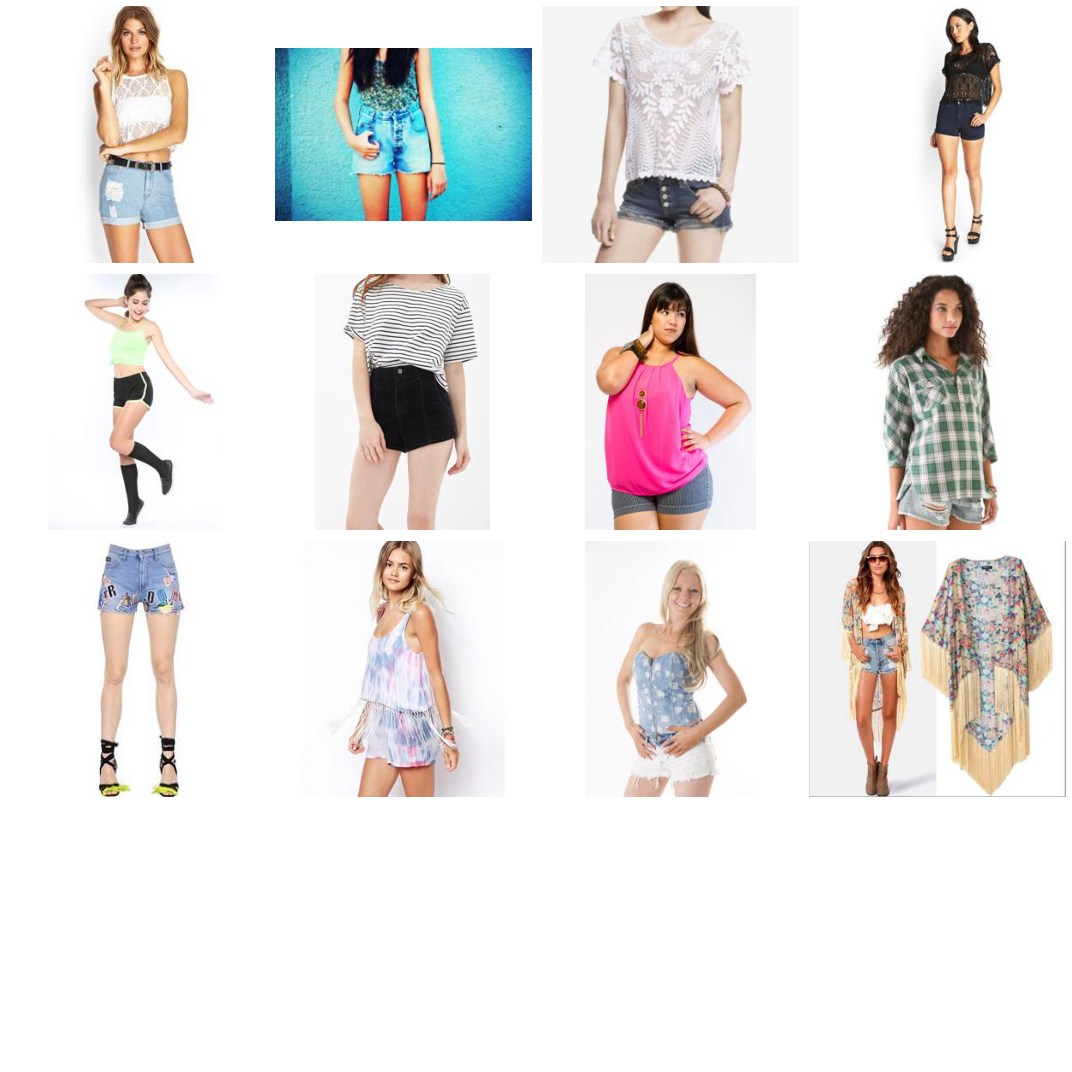

In [52]:
show_similar_images(outfits_selected, fig_size=[15,15])

That is a very good response from our model